### imports

In [24]:
%reload_ext autoreload
%autoreload 2

In [25]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [26]:
# analysis
from scipy.io import loadmat
from sklearn.decomposition import FastICA
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA

In [27]:
# misc
import pickle
from collections import defaultdict

In [28]:
from neural_plot_ult import *
import time
tic=time.time()
import warnings
warnings.filterwarnings('ignore')

# ICA(taskvar-neural shared latent, taskvar)

In [29]:
df = pd.read_pickle(resdir/'m51df.pkl')
len(df)
# df=df[df.session==38]

4803

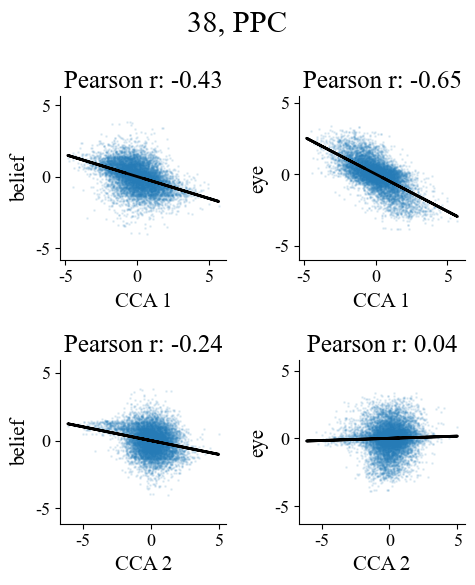

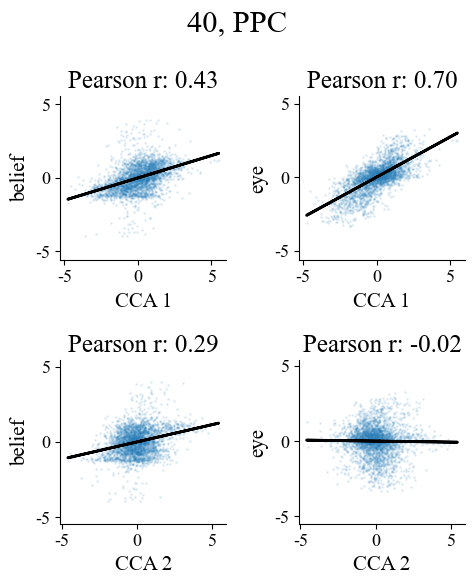

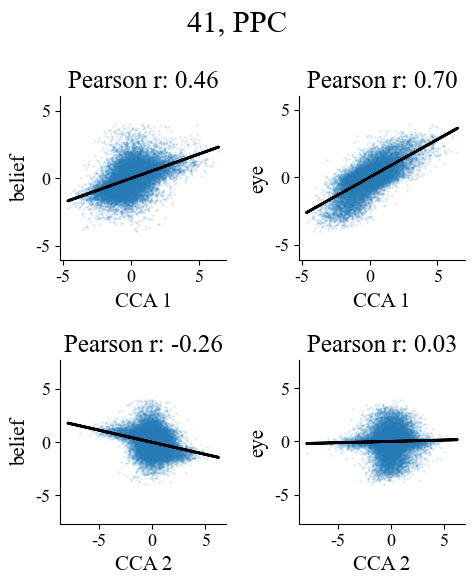

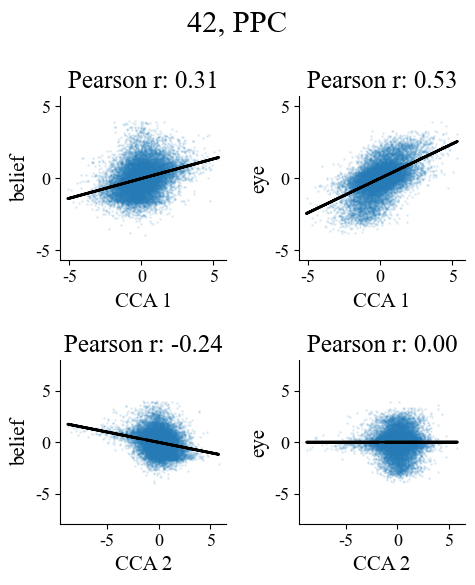

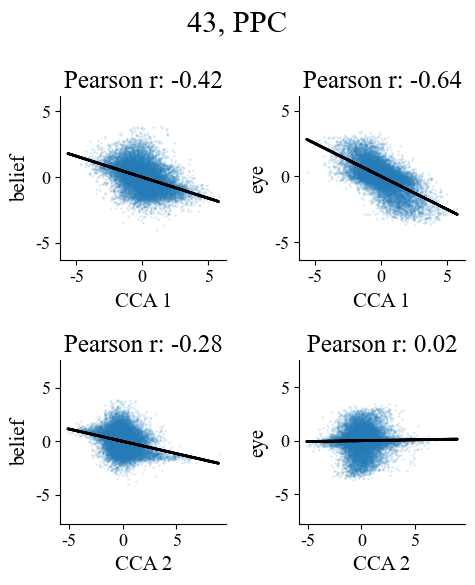

In [30]:
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]
    neural_data=np.concatenate(sessdf.PPC.to_numpy())
    rawtaskvar=[np.concatenate(sessdf.belief_ff_hori.to_numpy()),
           np.concatenate(sessdf.eye_hori.to_numpy()),
           ]
    # normalize to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    related_taskvar=np.vstack(rawtaskvar).T
    
    # related_taskvar=np.clip(related_taskvar,-4,4)
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    mask=(mask[:,0] & mask[:,1])
    related_taskvar=related_taskvar[mask]
    neural_data=neural_data[mask]
    
    
    cca = CCA(n_components=2)
    cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)


    varname=['belief', 'eye']
    fig, axs = plt.subplots(2,2, figsize=(5,6))
    for i in range(2):
        for j in range(2):
            ax=axs[i,j]
            ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
            # best fit line
            slope, intercept = np.polyfit(cca_neural[:,i],related_taskvar[:,j], 1)
            best_fit_line = slope * cca_neural[:,i] + intercept
            ax.plot(cca_neural[:,i], best_fit_line, color='black')
            # quickallspine(ax)
            ax.axis('equal')
            r,_=pearsonr(cca_neural[:,i],related_taskvar[:,j])
            # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
            ax.set_title(f'Pearson r: {r:.2f}')
            ax.set_xlabel(f'CCA {i+1}')
            ax.set_ylabel(f'{varname[j]}')
    plt.suptitle(f'{session}, PPC', fontsize=22)
    plt.tight_layout()
    plt.show()

(10459, 86) (10459, 2)


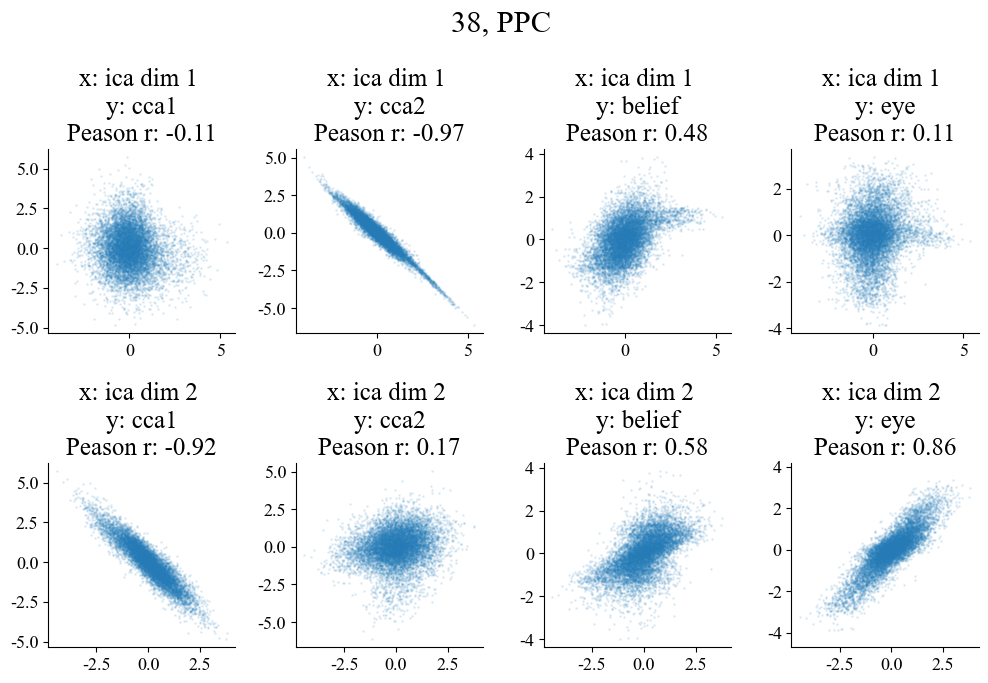

(3367, 66) (3367, 2)


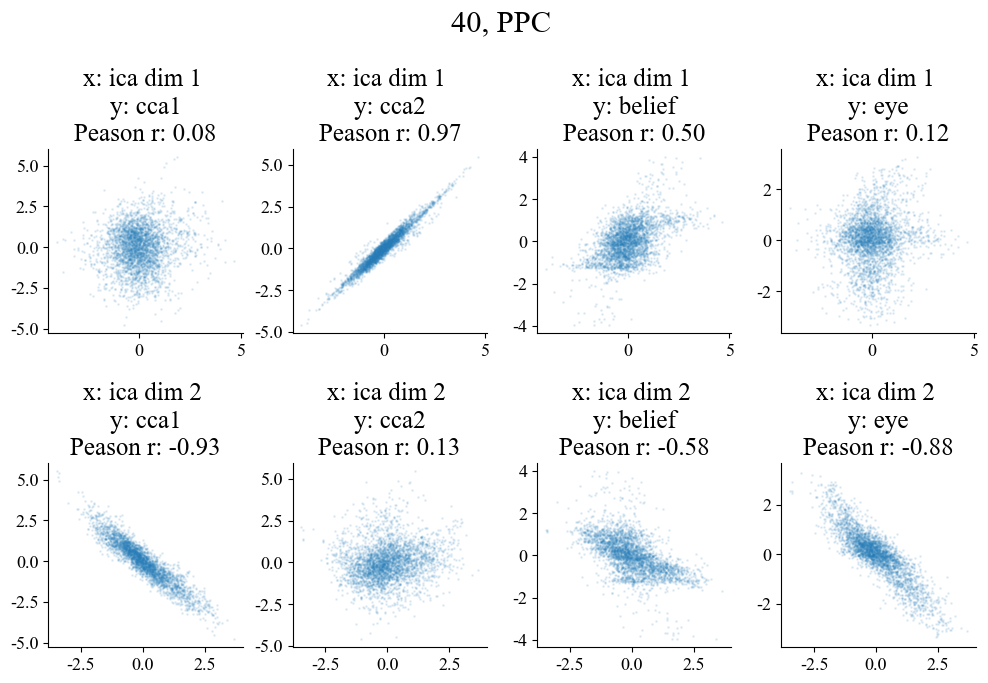

(24652, 112) (24652, 2)


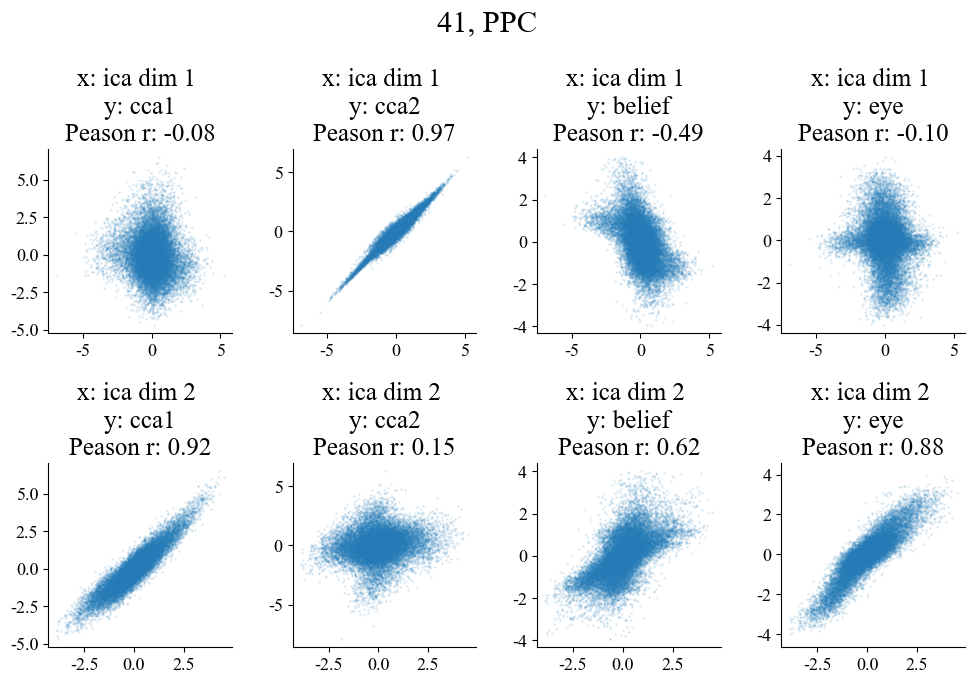

(18865, 104) (18865, 2)


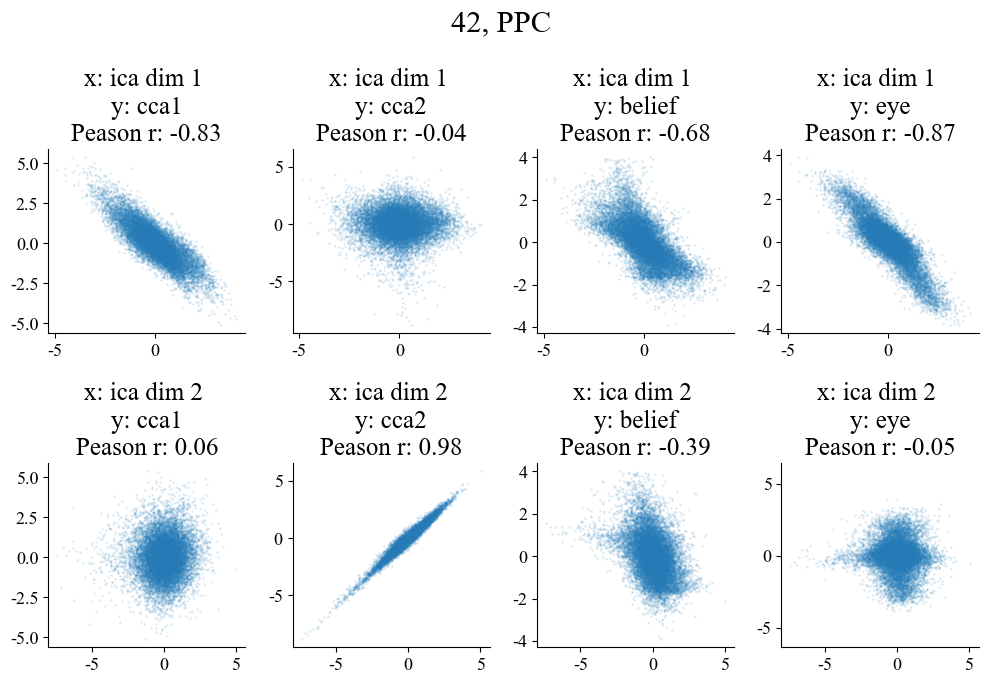

(18924, 94) (18924, 2)


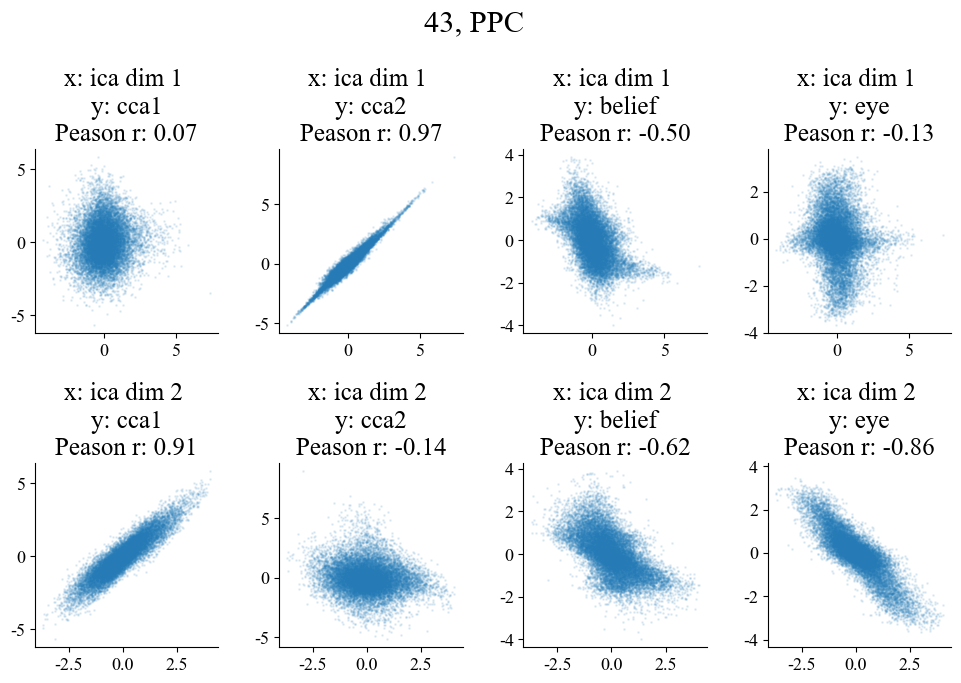

In [31]:
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]
    neural_data=np.concatenate(sessdf.PPC.to_numpy())
    rawtaskvar=[np.concatenate(sessdf.belief_ff_hori.to_numpy()),
           np.concatenate(sessdf.eye_hori.to_numpy()),
           ]
    # normalize to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    related_taskvar=np.vstack(rawtaskvar).T
    
    # related_taskvar=np.clip(related_taskvar,-4,4)
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    mask=(mask[:,0] & mask[:,1])
    # 1, set outlier to 0 (assumption, outlier is missing data, assign mean to them)
    # related_taskvar[~mask]=0
    # 2, remove outliers (no assumption)
    related_taskvar=related_taskvar[mask]
    neural_data=neural_data[mask]
    
    
    print(neural_data.shape, related_taskvar.shape)
    cca = CCA(n_components=2)
    cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)
    %matplotlib inline
    ica = FastICA(n_components=2)
    icaX=np.hstack([cca_neural,related_taskvar])
    icaS = ica.fit_transform(icaX) 

    varname=['cca1','cca2','belief', 'eye']
    fig, axs = plt.subplots(2,4, figsize=(10,7))
    for i in range(2):
        for j in range(4):
            ax=axs[i,j]
            ax.scatter(icaS[:,i],icaX[:,j], s=1, alpha=0.1)
            plt.axis('equal')
            r,_=pearsonr(icaS[:,i],icaX[:,j])
            ax.set_title(f'x: ica dim {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
    plt.suptitle(f'{session}, PPC', fontsize=22)
    plt.tight_layout()
    plt.show()

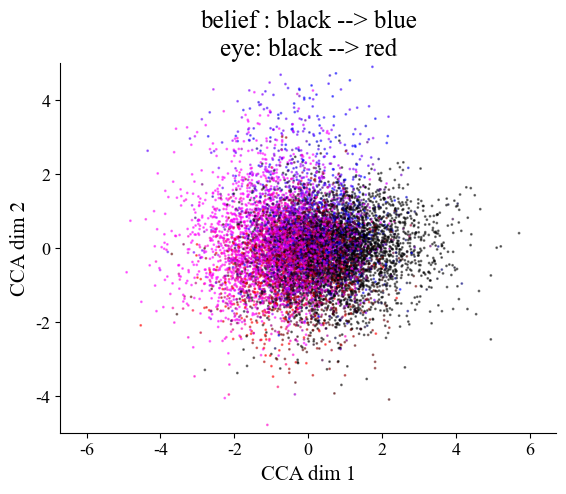

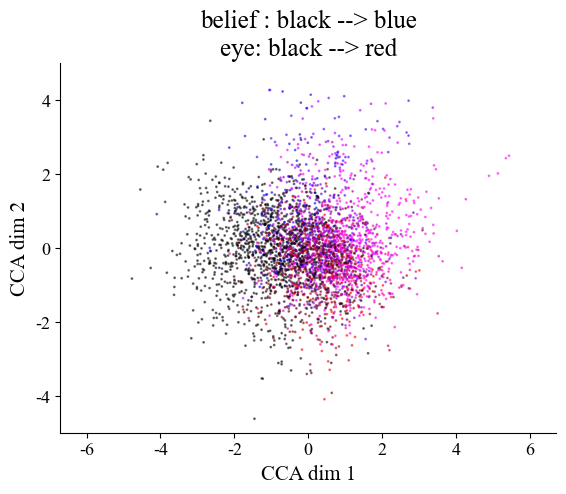

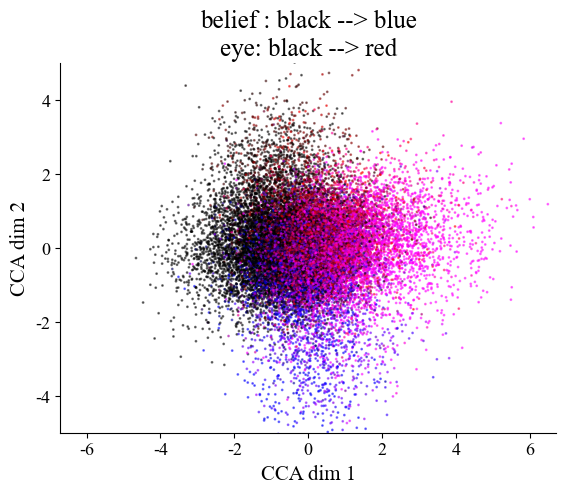

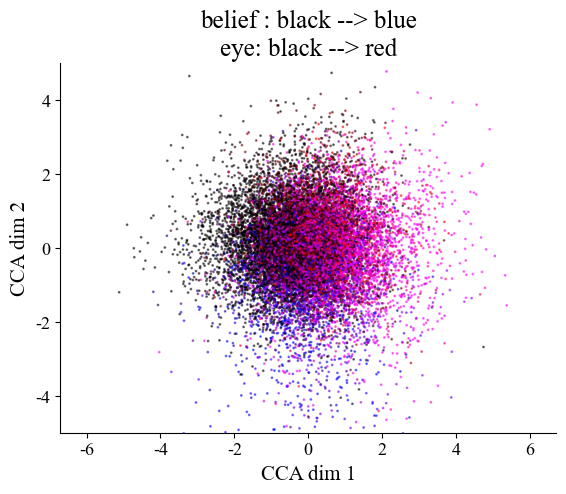

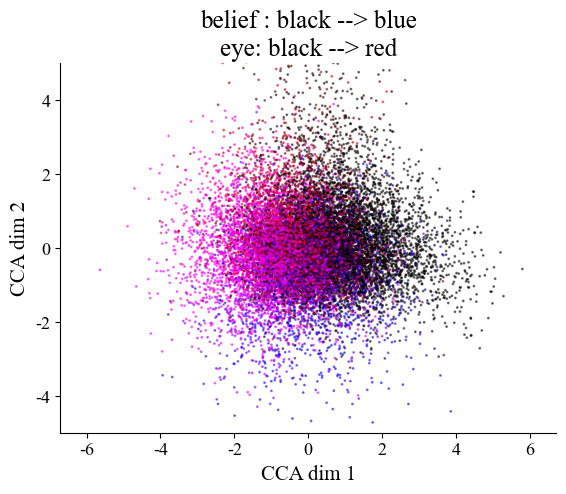

In [32]:
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]
    neural_data=np.concatenate(sessdf.PPC.to_numpy())
    rawtaskvar=[np.concatenate(sessdf.belief_ff_hori.to_numpy()),
           np.concatenate(sessdf.eye_hori.to_numpy()),
           ]
    # normalize to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    related_taskvar=np.vstack(rawtaskvar).T
    

    cca = CCA(n_components=2)
    cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)

    thisx,thisy=cca_neural[:,0],cca_neural[:,1]
    t1,t2=related_taskvar[:,0], related_taskvar[:,1]
    c1=np.array([0,0,1])
    c2=np.array([1,0,0])
    rgb_values=np.zeros((len(t1), 3))
    rgb_values[:,[0,2]]=0.3
    # rgb_values.shape, c1.shape, t1.shape
    rgb_values+=(c1[:, None]*t1).T
    rgb_values+=(c2[:, None]*t2).T

    rgb_values=(rgb_values)
    rgb_values=rgb_values.clip(0,1)
    hex_colors = [mcolors.rgb2hex(color) for color in rgb_values]
    plt.scatter(thisx, thisy, c=hex_colors,s=1, alpha=0.5)
    # quickallspine(plt.gca())
    plt.xlabel('CCA dim 1')
    plt.ylabel('CCA dim 2')
    plt.axis('equal')
    plt.xlim(-5,5)
    plt.ylim(-5,5) 
    # plt.title(f'{session} PPC\nbelief : black --> blue\neye: black --> red')
    plt.title(f'belief : black --> blue\neye: black --> red')
    plt.show()

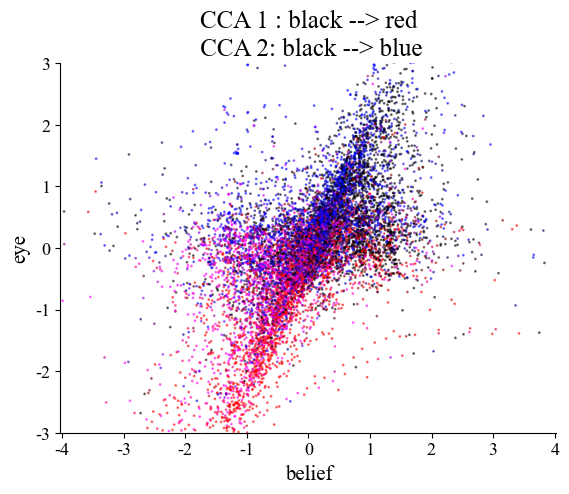

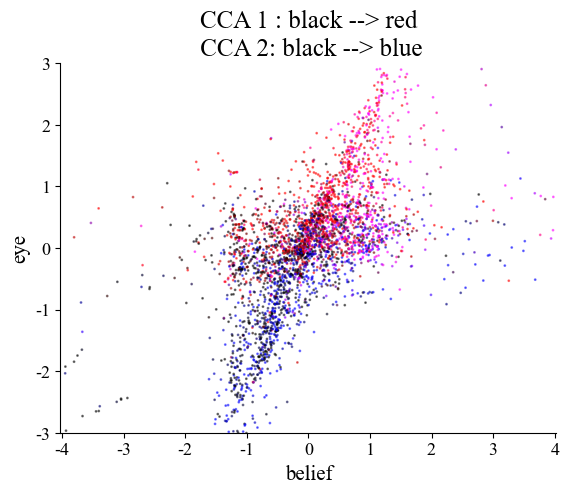

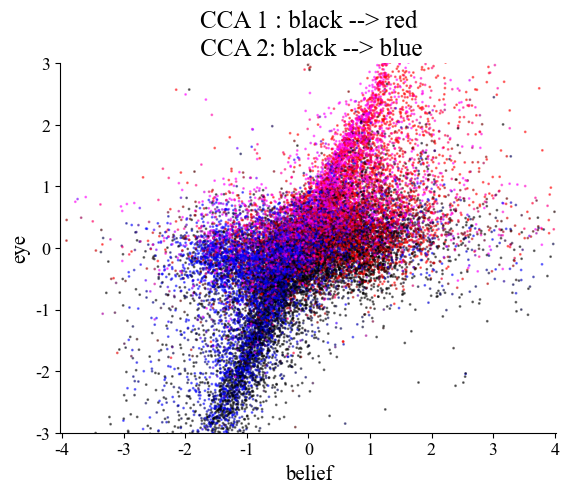

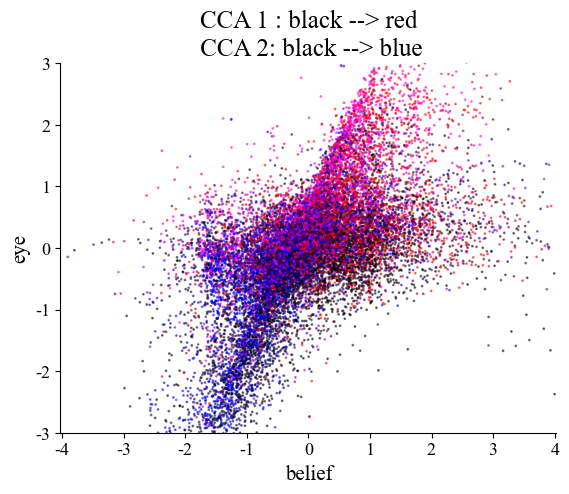

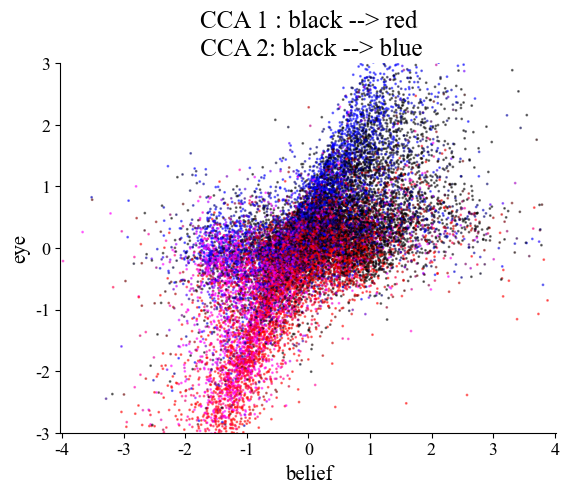

In [33]:
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]
    neural_data=np.concatenate(sessdf.PPC.to_numpy())
    rawtaskvar=[np.concatenate(sessdf.belief_ff_hori.to_numpy()),
           np.concatenate(sessdf.eye_hori.to_numpy()),
           ]
    # normalize to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    related_taskvar=np.vstack(rawtaskvar).T
    
    # related_taskvar=np.clip(related_taskvar,-4,4)
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    mask=(mask[:,0] & mask[:,1])
    # 1, set outlier to 0 (assumption, outlier is missing data, assign mean to them)
    # related_taskvar[~mask]=0
    # 2, remove outliers (no assumption)
    related_taskvar=related_taskvar[mask]
    neural_data=neural_data[mask]
    

    cca = CCA(n_components=2)
    cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)


    # fig, axs = plt.subplots(2,2, figsize=(7,6))
    # for i in range(2):
    #     for j,var in enumerate(['belief', 'eye movement']):
    #         ax=axs[i,j]
    #         ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
    #         plt.axis('equal')
    #         r=pearsonr(cca_neural[:,i],related_taskvar[:,j])[0]
    #         ax.set_title(f'Pearson R = {r:.2f}')
    #         ax.set_xlabel(f'CCA neural subspace {i+1}')
    #         ax.set_ylabel(f'{var}')
    #         ax.set_xticks([])
    #         ax.set_yticks([])

    # plt.suptitle(f'{dataname}, PPC', fontsize=22)
    # plt.tight_layout()
    # plt.show()

        
    thisx,thisy=related_taskvar[:,0], related_taskvar[:,1]
    t1,t2=cca_neural[:,0],cca_neural[:,1]

    c1=np.array([1,0,0])
    c2=np.array([0,0,1])
    rgb_values=np.zeros((len(t1), 3))
    rgb_values[:,[0,2]]=0.25
    # rgb_values.shape, c1.shape, t1.shape
    rgb_values+=(c1[:, None]*t1).T
    rgb_values+=(c2[:, None]*t2).T

    rgb_values=(rgb_values)
    rgb_values=rgb_values.clip(0,1)
    hex_colors = [mcolors.rgb2hex(color) for color in rgb_values]
    plt.scatter(thisx, thisy, c=hex_colors,s=1, alpha=0.5)
    # quickallspine(plt.gca())
    plt.xlabel('belief')
    plt.ylabel('eye')
    # plt.title('Scatter Plot with RGB Colors')
    plt.axis('equal')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    # plt.title(f'{session} PPC\nneural1 : black --> red\nneural 2: black --> blue')
    plt.title(f'CCA 1 : black --> red\n CCA 2: black --> blue')
    plt.show()

